In [9]:
from scipy.stats import randint
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from methods.helper import *
import graphviz
from IPython.display import Image
from methods.feature_selection import *
from IPython.display import display
from sklearn.tree import export_graphviz
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# Supress all warnings
import warnings
warnings.filterwarnings("ignore")

# 1. Random Forest

First, I will train the Random Forest method (with and without tuning) on the dataset.

_Random Forest Methods_

In [2]:
def random_forest(X_, Y_, tune_hyperparameters=True, n_folds=5):
    """
    Constructs multiple decision trees during training time and outputs the class
    that is the mode of the classes of the individual trees

    Adapted from:
    https://www.datacamp.com/tutorial/random-forests-classifier-python
    :param X_: Training set features
    :param Y_: Training set labels
    :param tune_hyperparameters: Whether to tune the hyperparameters
    :param n_folds: Number of folds for cross-validation
    :return:
    """

    # Hyperparameter tuning
    param_dist = {
        # Number of decision trees in the forest.
        # Generally, the higher, the better performance but it increases the computation cost
        'n_estimators': randint(200, 500),
        # The maximum depth of each tree in the forest
        # Higher values could lead to overfitting, while lower values could lead to underfitting
        'max_depth': range(2, 10),
        # The minimum number of samples required to split an internal node
        'min_samples_split': range(3, 10),
        # The minimum number of samples required to be at a leaf node
        'min_samples_leaf': range(1, 5),
        # The number of features to consider when looking for the best split
        'max_features': ["sqrt", "log2"],
        # The function to measure the quality of a split
        'criterion': ["gini", "entropy"]
    }

    if tune_hyperparameters:
        rf = RandomForestClassifier(random_state=42, bootstrap=True)
        # Perform randomized search on hyperparameters with n-fold cross-validation
        rand_search = RandomizedSearchCV(
            estimator=rf, param_distributions=param_dist, n_iter=10, cv=n_folds,
            random_state=42, n_jobs=-1, verbose=2, scoring='precision'
        )
        # Fit the model to the training data
        print(np.unique(Y_))
        rand_search.fit(X_, Y_)

        # Best parameters
        best_params = rand_search.best_params_
        for param_name in sorted(best_params.keys()):
            print(f"{param_name}: {best_params[param_name]}")

        # Return the best model
        return rand_search.best_estimator_

    else:
        rf = RandomForestClassifier(
            random_state=42, bootstrap=True,
            n_estimators=100, max_depth=5, min_samples_split=5, min_samples_leaf=5,
            max_features="sqrt", class_weight="balanced")
        
        # Fit the model to the entire training data
        rf.fit(X_, Y_)
        
        return rf

_Plotting Methods_

In [3]:
def plot_decision_trees(feature_names, rf_, num_trees=2):
    """
    Plot the decision trees of the random forest
    :param feature_names: Names of the features
    :param rf_: Random forest model
    :param num_trees: Number of trees to plot
    """
    
    for i in range(num_trees):
        tree = rf_.estimators_[i]
        dot_data = export_graphviz(
            tree,
            feature_names=feature_names,
            class_names=["Stable", "Slow Decliner", "Fast Decliner"],
            filled=True, rounded=True,
            max_depth=5,
            impurity=False,
            proportion=True,
            out_file=None,  
        )
        graph = graphviz.Source(dot_data, directory="trees")
        graph.render(f'tree_{i}', format='png')
        display(Image(filename=f'trees/tree_{i}.png'))

### Read Data

In [5]:
# Load the dataset
lipidomics, metabolomics, proteomics = load_data()
X_train, X_test, Y_train, y_test = concatenate_data(lipidomics, metabolomics, proteomics)
# Resample the data using SMOTE
X_train_resampled, Y_train_resampled = resampling(X_train, Y_train)

Resampled set shape: 
(99, 1112)
(99,)
Resampled set class distribution: 
 0    33
1    33
2    33
Name: ThreeClass, dtype: int64


Analysis of the distribution of the classes in the dataset

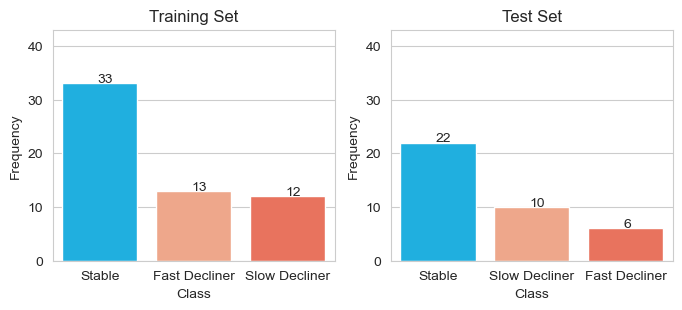

In [8]:
# Create a plot of the distribution of the classes in the training set
fig, axs = plt.subplots(1, 2, figsize=(8, 3))

colors = ['deepskyblue', 'lightsalmon', 'tomato']
labels = {0: 'Stable', 1: 'Slow Decliner', 2: 'Fast Decliner'}
Y_train_labels = Y_train.map(labels)
y_test_labels = y_test.map(labels)

Y_train_count = Y_train_labels.value_counts()
y_test_count = y_test_labels.value_counts()
y_lim = max(Y_train_count.max(), y_test_count.max()) + 10

# Add the count of each class on top of the bars
sns.barplot(x=Y_train_count.index, y=Y_train_count.values, ax=axs[0], palette=colors)

# Add the count of each class on top of the bars
for p, label in zip(axs[0].patches, Y_train_count.values):
    axs[0].annotate(label, (p.get_x()+0.375, p.get_height()+0.15))
    
axs[0].set_title("Training Set")
axs[0].set_xlabel("Class")
axs[0].set_ylabel("Frequency")
axs[0].set_ylim(0, y_lim)

sns.barplot(x=y_test_count.index, y=y_test_count.values, ax=axs[1], palette=colors)
for p, label in zip(axs[1].patches, y_test_count.values):
    axs[1].annotate(label, (p.get_x()+0.375, p.get_height()+0.15))

axs[1].set_title("Test Set")
axs[1].set_xlabel("Class")
axs[1].set_ylabel("Frequency")
axs[1].set_ylim(0, y_lim)
plt.show()


### Training of the Random Forest Model

First model will be trained on resampled data and with hyperparameter tuning

[0 1 2]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
criterion: gini
max_depth: 5
max_features: sqrt
min_samples_leaf: 3
min_samples_split: 5
n_estimators: 271
Accuracy of the model: 0.5263
Recall of the model: 0.5263
Precision of the model: 0.3993
Weighted F1 score of the model: 0.4507
Matthews Correlation Coefficient of the model: 0.0458


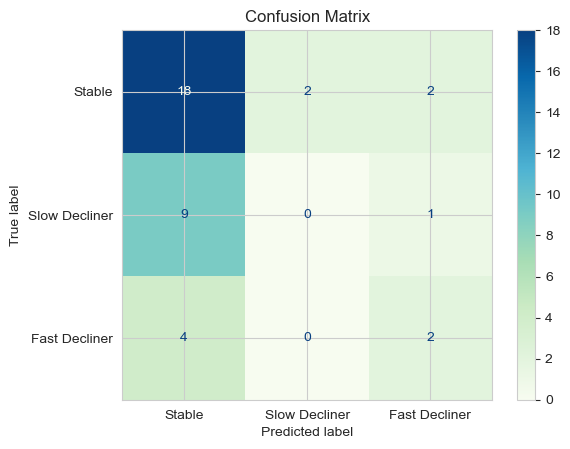

In [6]:
rf_resampling_tuning = random_forest(X_train_resampled, Y_train_resampled, True)

# Check the accuracy of the model
y_prediction = rf_resampling_tuning.predict(X_test)
evaluate_model(y_prediction, y_test)
plot_confusion_matrix(y_test, y_prediction)

Now, I won't tune the model

Accuracy of the model: 0.5526
Recall of the model: 0.5526
Precision of the model: 0.4069
Weighted F1 score of the model: 0.4648
Matthews Correlation Coefficient of the model: 0.0948


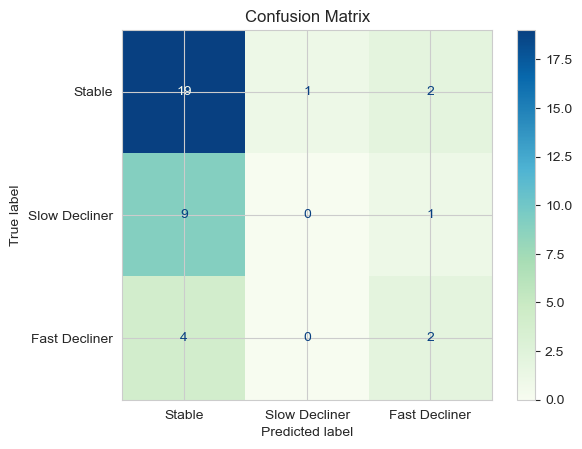

In [7]:
rf_resampling_tuning = random_forest(X_train_resampled, Y_train_resampled, False, 10)

# Check the accuracy of the model
y_prediction = rf_resampling_tuning.predict(X_test)
evaluate_model(y_prediction, y_test)
plot_confusion_matrix(y_test, y_prediction)

In [17]:
# Filter the data using MIFS
MIFS_features = recursive_feature_elimination(X_train, Y_train, 0.5)
X_train_filtered = X_train[MIFS_features]
X_test_filtered = X_test[MIFS_features]

Accuracy of the model: 0.6053
Recall of the model: 0.6053
Precision of the model: 0.8211
Weighted F1 score of the model: 0.6754
Matthews Correlation Coefficient of the model: 0.2072


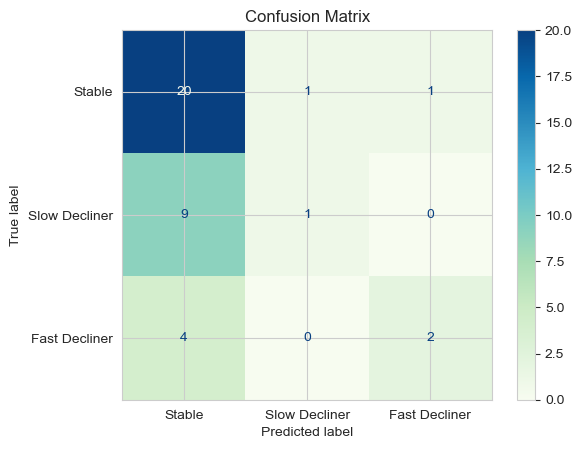

In [18]:
rf_filtered = random_forest(X_train_filtered, Y_train, False)
# Check the accuracy of the model
y_prediction = rf_filtered.predict(X_test_filtered)
evaluate_model(y_test, y_prediction)
plot_confusion_matrix(y_test, y_prediction)

Unfortunately for no feature selection method and hyperparmaters random forest was able to achieve good results.

# 2. XG Boost (eXtreme Gradient Boosting)

XG Boost model identifies the errors of the existing ensemble of trees by using the gradient of the loss function (which measures the difference between the predicted and actual outcomes). 
New trees are then added to reduce the loss function, focusing on correcting the errors of the previous trees.

XGBoost includes a regularization term in its objective function, which helps to control overfitting. This is a key difference from traditional gradient boosting methods, making XGBoost more powerful and effective.

[tutorial link](https://gist.github.com/alinaselega/a85a41b733c0eed1d5c607fad0cddc17)

[Avoiding Overfitting](https://stats.stackexchange.com/questions/443259/how-to-avoid-overfitting-in-xgboost-model)

[Hyperparameter Tuning](https://xgboost.readthedocs.io/en/stable/tutorials/param_tuning.html)

## Hyperparameter Tuning for XGBoost
(Next cell takes a while to run)

In [19]:
boost_model = xgb.XGBClassifier(objective='multi:softprob')
parameters = {
    # Learning rate
    "eta"    : [0.05, 0.10, 0.15, 0.20, 0.25],
    # Maximum depth of the tree
     "max_depth"        : [2, 3, 4, 5, 6, 8],
    # Minimum sum of instance weight (hessian) needed in a child
    "min_child_weight" : [3, 5, 7 ],
    # The fraction of samples to be used for fitting the individual base learners
     "gamma"            : [0.2 , 0.3, 0.4],
    # The fraction of features to be randomly samples for each tree
     "colsample_bytree" : [ 0.3, 0.4, 0.7 ],
    # The number of trees
     "n_estimators"     : [10, 20]
     }

grid = GridSearchCV(boost_model, parameters, n_jobs=4, cv=3)
grid.fit(X_train_resampled, Y_train_resampled)
print(grid.best_params_)

{'colsample_bytree': 0.3, 'eta': 0.2, 'gamma': 0.2, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 10}


Accuracy of the model: 0.5263
Recall of the model: 0.5263
Precision of the model: 0.4673
Weighted F1 score of the model: 0.4862
Matthews Correlation Coefficient of the model: 0.0903


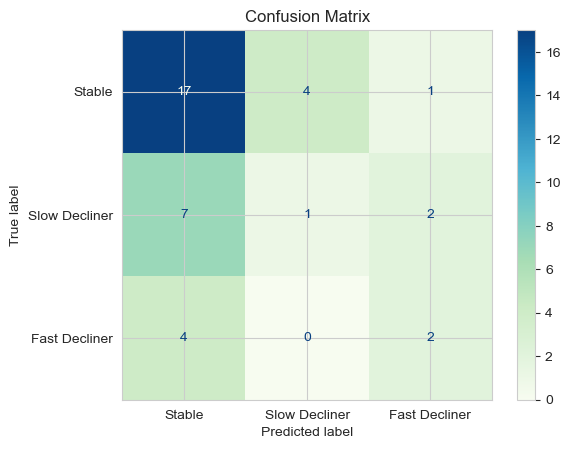

In [21]:
prediction_test = grid.predict(X_test)
evaluate_model(prediction_test, y_test)
plot_confusion_matrix(y_test, prediction_test)

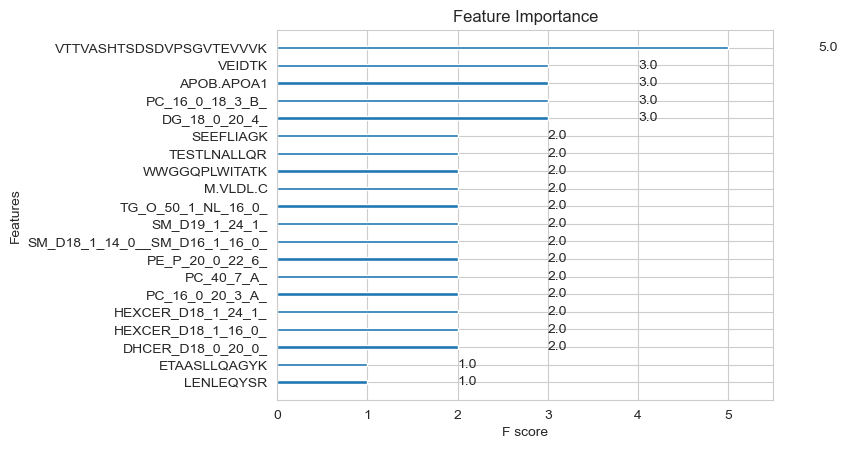

In [22]:
top_feature_num = 20
xgb.plot_importance(grid.best_estimator_, max_num_features=top_feature_num)
plt.title('Feature Importance')
plt.show()

Custom XGboost model with no hyperparameter tuning

In [23]:
custom_boost_model = xgb.XGBClassifier(
    objective='multi:softprob',
    
    # Control model complexity to prevent overfitting
    max_depth=4, # default=6
    min_child_weight=3, # default=1
    gamma=0.2, # default=0
    
    # Add randomness to make training robust to noise
    colsample_bytree=0.3, # default=1 (Subsample ratio of columns when constructing each tree)
    subsample=0.7, # default=1 (Subsample ratio of the training instances)
    eta=0.1, # default=0.3 (Learning rate)
    num_round=500 # default=100 (Number of boosting rounds)
)

custom_boost_model.fit(X_train_resampled, Y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.3, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric=None,
              feature_types=None, gamma=0.2, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=3, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

Accuracy of the model: 0.5263
Recall of the model: 0.5263
Precision of the model: 0.4673
Weighted F1 score of the model: 0.4862
Matthews Correlation Coefficient of the model: 0.0903


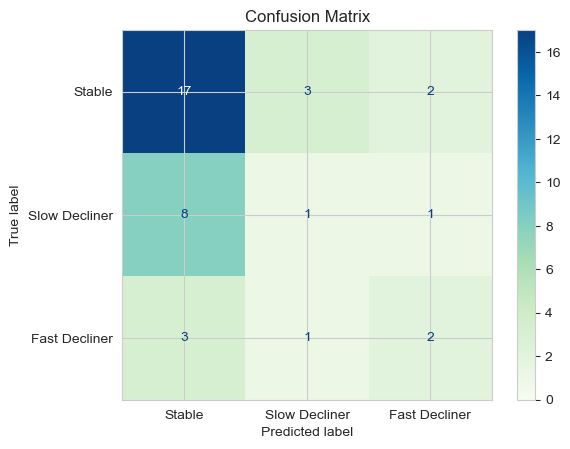

In [24]:
# Check the accuracy of the model
y_prediction = custom_boost_model.predict(X_test)
evaluate_model(y_prediction, y_test)
plot_confusion_matrix(y_test, y_prediction)

In the end, I will try to run the model on the filtered dataset.

In [25]:
boost_model = xgb.XGBClassifier(objective='multi:softprob')
grid = GridSearchCV(boost_model, parameters, n_jobs=4, cv=3)
grid.fit(X_train_filtered, Y_train)
print(grid.best_params_)

{'colsample_bytree': 0.4, 'eta': 0.2, 'gamma': 0.2, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 20}


Accuracy of the model: 0.5263
Recall of the model: 0.5263
Precision of the model: 0.4791
Weighted F1 score of the model: 0.4978
Matthews Correlation Coefficient of the model: 0.1215


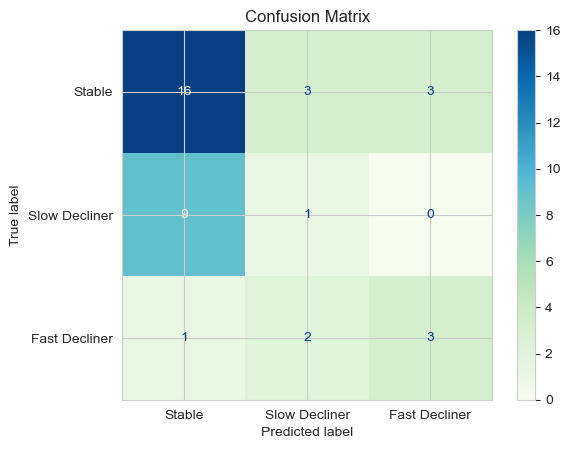

In [28]:
prediction_test = grid.predict(X_test_filtered)
evaluate_model(prediction_test, y_test)
plot_confusion_matrix(y_test, prediction_test)